## NIREN PATEL IRDM STANCE DETECTION BOOK 3

In [0]:
#!kill -9 -1 # Kill Switch Do not run this cell

In [2]:
!ls

datalab			    TrainAgree.csv	ValidationAgree.csv
nltk_data		    train_bodies.csv	ValidationDisagree.csv
test_bodies.csv		    TrainDisagree.csv	ValidationDiscuss.csv
TestforLearning.csv	    TrainDiscuss.csv	ValidationUnrelated.csv
test_stances_unlabeled.csv  train_stances.csv
TestWithStances.csv	    TrainUnrelated.csv


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
TrainProcessed = drive.CreateFile({'id':'12IgQVJPo-oznDjoy4qp-yBEv0wvjx-6I'}) 
TrainProcessed.GetContentFile('TrainProcessed.csv')  

ValidationProcessed = drive.CreateFile({'id':'1ao3ZMAwle7W9ZBPZ-lVPHmqFlhMHJ9hs'}) 
ValidationProcessed.GetContentFile('ValidationProcessed.csv')

TestProcessed = drive.CreateFile({'id':'1sOMZL3UQbnJXOxrDoQDBpm4a8GNeACaH'}) 
TestProcessed.GetContentFile('TestProcessed.csv')

In [4]:
#IMPORT PACKAGES
import numpy as np
import pandas as pd
import re
import math
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
import string
from  itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from math import exp

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#Read file as panda dataframe
TrainProcessed = pd.read_csv('TrainProcessed.csv')
ValidationProcessed = pd.read_csv('ValidationProcessed.csv')
TestProcessed = pd.read_csv('TestProcessed.csv')

# PUNCTUATION REMOVAL AND TOKENISATION

In [0]:
#PUNCTUATION REMOVAL
TrainProcessed['Headline']         =  TrainProcessed["Headline"].apply(lambda x: re.sub(r'[^\w\s]', '',x))
TrainProcessed['articleBody']      =  TrainProcessed["articleBody"].apply(lambda x: re.sub(r'[^\w\s]', '',x))
TestProcessed['Headline']          =  TestProcessed["Headline"].apply(lambda x: re.sub(r'[^\w\s]', '',x))
TestProcessed['articleBody']       =  TestProcessed["articleBody"].apply(lambda x: re.sub(r'[^\w\s]', '',x))
ValidationProcessed['Headline']    =  ValidationProcessed["Headline"].apply(lambda x: re.sub(r'[^\w\s]', '',x))
ValidationProcessed['articleBody'] =  ValidationProcessed["articleBody"].apply(lambda x: re.sub(r'[^\w\s]', '',x))

In [0]:
#TOKENISATION
TrainProcessed['Headline']         =  TrainProcessed["Headline"].apply(nltk.word_tokenize)
TrainProcessed['articleBody']      =  TrainProcessed["articleBody"].apply(nltk.word_tokenize)
TestProcessed['Headline']          =  TestProcessed["Headline"].apply(nltk.word_tokenize)
TestProcessed['articleBody']       =  TestProcessed["articleBody"].apply(nltk.word_tokenize)
ValidationProcessed['Headline']    =  ValidationProcessed["Headline"].apply(nltk.word_tokenize)
ValidationProcessed['articleBody'] =  ValidationProcessed["articleBody"].apply(nltk.word_tokenize)

# LAPLACE SMOOTHING

In [0]:
#Function for QueryLieklihood
def QueryLikelihoodLaplaceSmoothing(dataset):
  DictionaryList= []
  for index, row  in dataset.iterrows():
    DictionaryHeadline = {}
    UniqueHeadline = []
    [UniqueHeadline.append(i) for i in row.Headline if not UniqueHeadline.count(i)]  
    
    for headlineWord in UniqueHeadline:
      DictionaryHeadline[headlineWord]=1 
      for bodyWord in row.articleBody:
        DictionaryHeadline[bodyWord]=1

    for headlineWord in UniqueHeadline:
      if headlineWord in row.articleBody:
        countWord = row.articleBody.count(headlineWord)
        DictionaryHeadline[headlineWord] = DictionaryHeadline[headlineWord] + countWord
      else:
        pass
    TotalWords = sum(DictionaryHeadline.values())
    for key in DictionaryHeadline:
      DictionaryHeadline[key] /= TotalWords
    DictionaryList.append(DictionaryHeadline)
  return DictionaryList

In [0]:
#Function for DocumentLikelihood
def DocumentLikelihoodLaplaceSmoothing(dataset):
  DictionaryList= []
  for index, row  in dataset.iterrows():
    DictionaryBody = {}
    UniqueBody = []
    [UniqueBody.append(i) for i in row.articleBody if not UniqueBody.count(i)]  

    for bodyWord in UniqueBody:
      DictionaryBody[bodyWord]=1
      for headlineWord in row.Headline:
        DictionaryBody[headlineWord]=1 


    for bodyWord in UniqueBody:
      if bodyWord in row.Headline:
        countWord = row.Headline.count(bodyWord)
        DictionaryBody[bodyWord] = DictionaryBody[bodyWord] + countWord
      else:
        pass
    TotalWords = sum(DictionaryBody.values())
    for key in DictionaryBody:
      DictionaryBody[key] /= TotalWords
    DictionaryList.append(DictionaryBody)
  return DictionaryList

In [0]:
#Get Prbability Distributions for each model
TrainQueryLikelihoodLaplace         = QueryLikelihoodLaplaceSmoothing(TrainProcessed)
ValidationQueryLikelihoodLaplace    = QueryLikelihoodLaplaceSmoothing(ValidationProcessed)
TestQueryLikelihoodLaplace          = QueryLikelihoodLaplaceSmoothing(TestProcessed)

TrainDocumentLikelihoodLaplace      = DocumentLikelihoodLaplaceSmoothing(TrainProcessed)
ValidationDocumentLikelihoodLaplace = DocumentLikelihoodLaplaceSmoothing(ValidationProcessed)
TestDocumentLikelihoodLaplace       = DocumentLikelihoodLaplaceSmoothing(TestProcessed)


In [0]:
trainLikelihoods = pd.DataFrame(list(zip(TrainQueryLikelihoodLaplace, TrainDocumentLikelihoodLaplace )), columns = ['qldict', 'dldict'])
validationLikelihoods = pd.DataFrame(list(zip(ValidationQueryLikelihoodLaplace, ValidationDocumentLikelihoodLaplace )), columns = ['qldict', 'dldict'])
testLikelihoods = pd.DataFrame(list(zip(TestQueryLikelihoodLaplace, TestDocumentLikelihoodLaplace )), columns = ['qldict', 'dldict'])

In [0]:
def DictionaryToValues(DictionaryOfProbabilities):
  querylikelihoodsValues = []
  documentlikelihoodsValues = []
  for index,row in DictionaryOfProbabilities.iterrows():
    querylikelihoodtemplist = []
    documentlikelihoodtemplist = []
    for k in row.qldict.keys() & row.dldict.keys():
      querylikelihoodtemplist.append(row.qldict[k])
      documentlikelihoodtemplist.append(row.dldict[k])
    querylikelihoodsValues.append(querylikelihoodtemplist)
    documentlikelihoodsValues.append(documentlikelihoodtemplist)
  return querylikelihoodsValues, documentlikelihoodsValues
    
    

In [0]:
TrainQueryLikelihoodsValues, TrainDocumentLikelihoodsValues = DictionaryToValues(trainLikelihoods)
ValidationQueryLikelihoodsValues, ValidationDocumentLikelihoodsValues = DictionaryToValues(validationLikelihoods)
TestQueryLikelihoodsValues, TestDocumentLikelihoodsValues = DictionaryToValues(testLikelihoods)

In [0]:
trainLikelihoodValues = pd.DataFrame(list(zip(TrainQueryLikelihoodsValues, TrainDocumentLikelihoodsValues )), columns = ['qlValues', 'dlValues'])
validationLikelihoodValues = pd.DataFrame(list(zip(ValidationQueryLikelihoodsValues, ValidationDocumentLikelihoodsValues )), columns = ['qlValues', 'dlValues'])
testLikelihoods=Values = pd.DataFrame(list(zip(TestQueryLikelihoodsValues, TestDocumentLikelihoodsValues )), columns = ['qlValues', 'dlValues'])

In [0]:
TrainWithLikelihoods = pd.concat([TrainProcessed, trainLikelihoodValues], axis=1, join_axes=[TrainProcessed.index])
ValidationWithLikelihoods = pd.concat([ValidationProcessed, validationLikelihoodValues], axis=1, join_axes=[ValidationProcessed.index])
TestWithLikelihoods = pd.concat([TestProcessed, testLikelihoods], axis=1, join_axes=[TestProcessed.index])

# KL DIVERGENCE

In [0]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [0]:
TrainWithLikelihoods['KLDivergence'] = TrainWithLikelihoods.apply(lambda x: KL(x['qlValues'], x['dlValues']), axis=1)
ValidationWithLikelihoods['KLDivergence'] = ValidationWithLikelihoods.apply(lambda x: KL(x['qlValues'], x['dlValues']), axis=1)
TestWithLikelihoods['KLDivergence'] = TestWithLikelihoods.apply(lambda x: KL(x['qlValues'], x['dlValues']), axis=1)

# DISTRIBUTION PLOT

In [18]:
TrainWithLikelihoods.groupby('Stance').mean()

,Unnamed: 0,Body ID,CosineSim,KLDivergence
Stance,,,,
agree,25202.699339,1625.703548,0.294215,0.036388
disagree,24252.781501,1621.730563,0.275860,0.038886
discuss,24994.413548,1649.028318,0.295782,0.044528
unrelated,25021.427494,1269.826649,0.015391,0.001538


In [0]:
ValidationWithLikelihoods.groupby('Stance').mean()
TESTINGPRECISION = TrainWithLikelihoods[TrainWithLikelihoods.Stance != 'discuss']

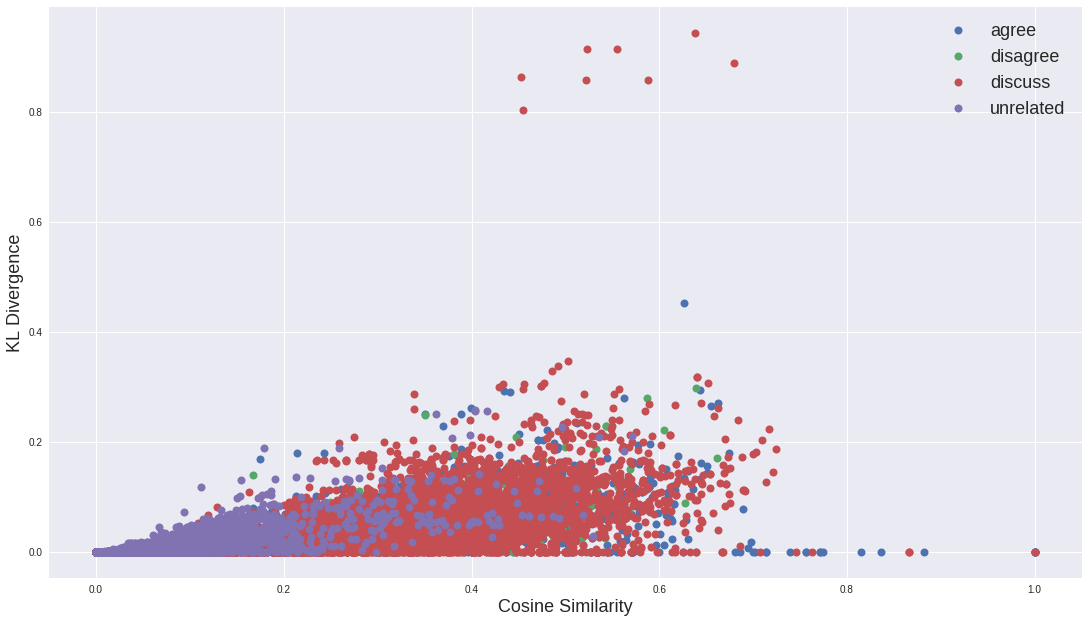

In [49]:
groups = TrainWithLikelihoods.groupby('Stance')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for name, group in groups:
    ax.plot(group.CosineSim, group.KLDivergence, marker='o', linestyle='', ms=8, label=name)
ax.legend()
ax.set_xlabel('Cosine Similarity',fontsize=18)
ax.set_ylabel('KL Divergence', fontsize=18)
plt.legend(loc=1, prop={'size': 18})
plt.show()

# SAVE FILES AND HOT ENCODE FOR MACHINE LEARNING

In [0]:
#ONE HOT ENCODE THE STANCES
TrainBinary = TrainWithLikelihoods.drop(['Headline', 'Body ID','articleBody','Unnamed: 0','qlValues','dlValues'], axis=1)
ValidationBinary = ValidationWithLikelihoods.drop(['Headline', 'Body ID','articleBody','Unnamed: 0','qlValues','dlValues'], axis=1)
TestBinary = TestWithLikelihoods.drop(['Headline', 'Body ID','articleBody','Unnamed: 0','qlValues','dlValues'], axis=1)

In [0]:
TrainBinary = pd.get_dummies(TrainBinary, prefix=['Stance'])
ValidationBinary = pd.get_dummies(ValidationBinary,prefix = ['Stance'])

In [0]:
#GET TARGETS Train
TrainAgree = TrainBinary[['CosineSim','KLDivergence','Stance_agree']]
TrainDisagree = TrainBinary[['CosineSim','KLDivergence','Stance_disagree']]
TrainDiscuss = TrainBinary[['CosineSim','KLDivergence','Stance_discuss']]
TrainUnrelated = TrainBinary[['CosineSim','KLDivergence','Stance_unrelated']]


#GET TARGETS Validation
ValidationAgree = ValidationBinary[['CosineSim','KLDivergence','Stance_agree']]
ValidationDisagree = ValidationBinary[['CosineSim','KLDivergence','Stance_disagree']]
ValidationDiscuss = ValidationBinary[['CosineSim','KLDivergence','Stance_discuss']]
ValidationUnrelated = ValidationBinary[['CosineSim','KLDivergence','Stance_unrelated']]

In [0]:
#ONLY WORKS IN CHROME  #Code to save files for next stage
TrainAgree = pd.DataFrame(TrainAgree).to_csv('TrainAgree.csv')
TrainDisagree = pd.DataFrame(TrainDisagree).to_csv('TrainDisagree.csv')
TrainDiscuss = pd.DataFrame(TrainDiscuss).to_csv('TrainDiscuss.csv')
TrainUnrelated = pd.DataFrame(TrainUnrelated).to_csv('TrainUnrelated.csv')

ValidationAgree = pd.DataFrame(ValidationAgree).to_csv('ValidationAgree.csv')
ValidationDisagree = pd.DataFrame(ValidationDisagree).to_csv('ValidationDisagree.csv')
ValidationDiscuss = pd.DataFrame(ValidationDiscuss).to_csv('ValidationDiscuss.csv')
ValidationUnrelated = pd.DataFrame(ValidationUnrelated).to_csv('ValidationUnrelated.csv')

TestforLearning = pd.DataFrame(TestBinary).to_csv('TestforLearning.csv')

In [0]:
from google.colab import files
files.download('TrainAgree.csv')
files.download('TrainDisagree.csv')
files.download('TrainDiscuss.csv')
files.download('TrainUnrelated.csv')

files.download('ValidationAgree.csv')
files.download('ValidationDisagree.csv')
files.download('ValidationDiscuss.csv')
files.download('ValidationUnrelated.csv')

files.download('TestforLearning.csv')
